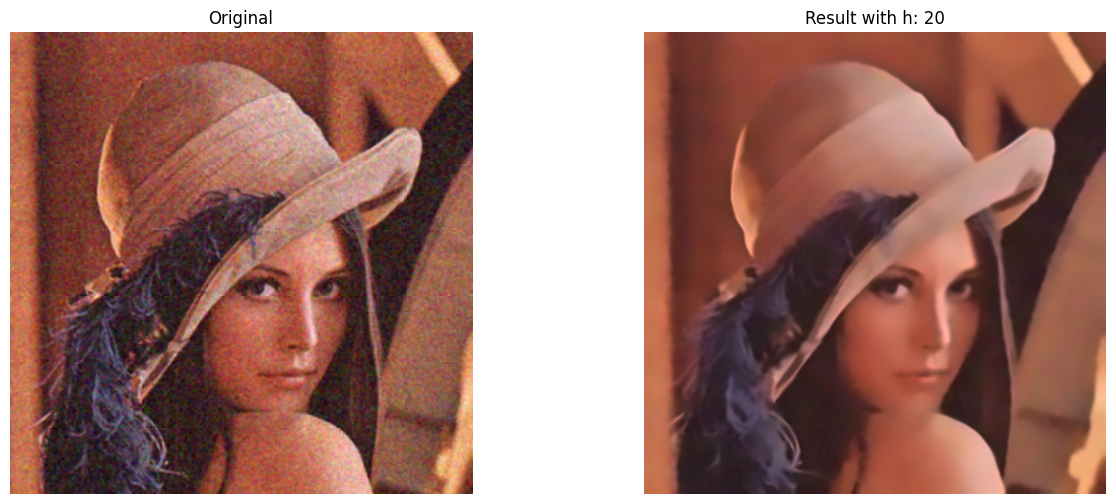

In [35]:
import cv2
from matplotlib import pyplot as plt

image = cv2.imread("output/lena_bruit_pca_100_gauss_06_median_3_size_70.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB

dst = cv2.fastNlMeansDenoisingColored(image_rgb, None, 20, 40, 7, 21)

##

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Result")
plt.imshow(dst)
plt.axis("off")

plt.show()


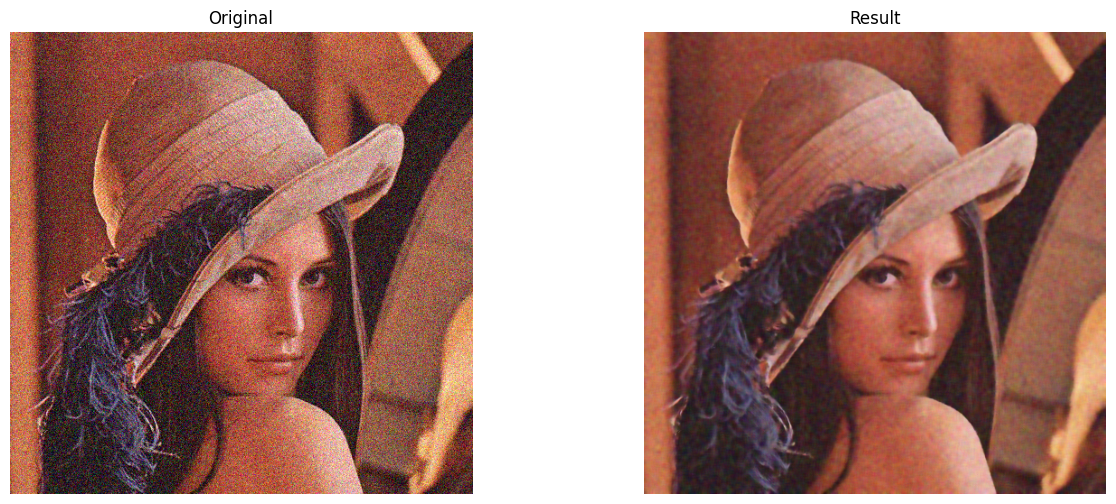

In [42]:
import numpy as np
import cv2
from skimage import img_as_float
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

def nlm_denoise(image, patch_size=12, search_window_size=21, h=10):
    """
    Non-Local Means Denoising Algorithm
    
    Parameters:
    - image: Input noisy image (numpy array)
    - patch_size: Size of the patch (default is 3)
    - search_window_size: Size of the search window (default is 21)
    - h: Filtering parameter (default is 10)
    
    Returns:
    - Denoised image
    """
    # Convert image to float
    image = img_as_float(image)
    denoised = np.zeros_like(image)
    
    pad_size = search_window_size // 2
    patch_radius = patch_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'reflect')
    
    # Precompute Gaussian weights for the patch
    gaussian_kernel = np.exp(-0.5 * (np.linspace(-patch_radius, patch_radius, patch_size) ** 2) / (h ** 2))
    gaussian_kernel = gaussian_kernel[:, None] * gaussian_kernel[None, :]
    
    # Extract patches from the image
    patches = np.lib.stride_tricks.as_strided(
        padded_image,
        shape=(padded_image.shape[0] - patch_size + 1, padded_image.shape[1] - patch_size + 1, patch_size, patch_size, image.shape[2]),
        strides=padded_image.strides[:2] + padded_image.strides[:2] + padded_image.strides[2:]
    )
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            i1 = i + pad_size
            j1 = j + pad_size
            ref_patch = padded_image[i1-patch_radius:i1+patch_radius+1, j1-patch_radius:j1+patch_radius+1, :]
            
            # Extract search window
            i_min = max(i1 - pad_size, 0)
            i_max = min(i1 + pad_size + 1, padded_image.shape[0] - patch_size + 1)
            j_min = max(j1 - pad_size, 0)
            j_max = min(j1 + pad_size + 1, padded_image.shape[1] - patch_size + 1)
            
            search_window = patches[i_min:i_max, j_min:j_max]
            search_window = search_window.reshape(-1, patch_size, patch_size, image.shape[2])
            
            # Compute the distances
            distances = np.sum((search_window - ref_patch[None, :, :, :]) ** 2 * gaussian_kernel[None, :, :, None], axis=(1, 2, 3))
            
            # Compute weights
            weights = np.exp(-distances / (h ** 2))
            weights /= np.sum(weights)
            
            # Compute denoised pixel value
            denoised[i, j, :] = np.sum(weights[:, None] * search_window[:, patch_radius, patch_radius, :], axis=0)
    
    return denoised


image = cv2.imread("src/lena_bruit.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

dst = nlm_denoise(image_rgb, patch_size=3, search_window_size=5, h=1)

##

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Result")
plt.imshow(dst)
plt.axis("off")

plt.show()